In [1]:
import pandas as pd 
import simfin as sf
from simfin.names import *
import math
import yfinance as yf

In [2]:
def calculate_growth_rate(start, end, years):
    return (end/start)**(1/years) - 1

In [3]:
# set up
sf.set_api_key('free')
sf.set_data_dir('./simfin_data/')

df_income = sf.load_income(variant='annual', market='us')
df_balance = sf.load_balance(variant='annual', market='us')
df_cashflow = sf.load_cashflow(variant='annual', market='us')

Dataset "us-income-annual" on disk (18 days old).
- Loading from disk ... Done!
Dataset "us-balance-annual" on disk (18 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-annual" on disk (18 days old).
- Loading from disk ... Done!


In [4]:
# roic
operating_income = df_income[OP_INCOME]
tax_rate = -(df_income[INCOME_TAX]/df_income[PRETAX_INCOME_LOSS_ADJ]) # how to handle > 1 or < 0
nopat = operating_income * (1 - tax_rate)
invested_capital = df_balance[ST_DEBT].fillna(0) + df_balance[LT_DEBT].fillna(0) + df_balance[TOTAL_EQUITY]

roic = (nopat/invested_capital).rename('ROIC')

# Big four numbers
eps = (df_income[NET_INCOME] / df_income[SHARES_BASIC]).rename('EPS')
revenue = df_income[REVENUE]
equity = df_balance[TOTAL_EQUITY]
cash = df_balance[CASH_EQUIV_ST_INVEST]

In [5]:
big_five_df = pd.DataFrame([revenue, equity, cash, eps, roic])

# Stock screening

# Big Five analysis
In descending order of importance:
1. ROIC
2. Equity
3. EPS
4. Sales
5. Cash

In [6]:
tickers_set = set()

for ((ticker, _), _) in big_five_df.iteritems():
    tickers_set.add(ticker)

In [7]:
'C649' in tickers_set

True

In [8]:
# Growth rates calculation
n_year_growth_rates = [10, 5, 3, 1] # n-year growth rates to calculate
columns = ['ticker', 'financial'] + [f'{year}-year growth rate' for year in n_year_growth_rates]
growth_rate_df = pd.DataFrame(columns=columns)

for ticker in tickers_set:
    single_stock_df = big_five_df[ticker]
    for financial in [TOTAL_EQUITY, CASH_EQUIV_ST_INVEST, REVENUE, 'EPS', 'ROIC']:
        row = [ticker, financial]
        for years in n_year_growth_rates:
            try:
                start_value = single_stock_df[single_stock_df.columns[-years-1]][financial]
                end_value = single_stock_df[single_stock_df.columns[-1]][financial]
                growth_rate = calculate_growth_rate(start_value, end_value, years)
            except:
                # return nan if value does not exist, or if end_value/start_value is negative
                growth_rate = math.nan
            row.append(growth_rate)
        growth_rate_df = growth_rate_df.append(
            pd.Series(row, index = columns),
            ignore_index = True)

growth_rate_df = growth_rate_df.set_index('ticker')
growth_rate_df = growth_rate_df.set_index('financial', append=True)

C:\Users\Donovan\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\Donovan\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


In [9]:
potential_buys = []

def check_is_potential_buy(df, allowed_failed = 0):
    failed_counter = 0
    # iterate over each cell
    for rowIndex, row in df.iterrows():
        for columnIndex, value in row.items():
            if math.isnan(value) or value < 0.1:
                failed_counter += 1
    # change to adjust leniency
    return failed_counter <= allowed_failed

for ticker in tickers_set:
    df = growth_rate_df.T[ticker]
    if(check_is_potential_buy(df, 3)):
        potential_buys.append(ticker)

potential_buys

['AMZN', 'LULU', 'NFLX', 'CNC', 'ASGN']

In [10]:
len(tickers_set)
old_potential_buys = ['FND',
 'GOV',
 'BB',
 'ESTC',
 'GOEV',
 'ANET',
 'CORT',
 'ABMD',
 'JDAS',
 'PINS',
 'CHNG',
 'VIVE',
 'MXMG',
 'LULU',
 'ARCP',
 'KONA',
 'SHLL',
 'BRBR',
 'DCPH',
 'FNJN',
 'CACC',
 'KMG',
 'MRCY',
 'ALR',
 'ODT',
 'COVS',
 'MACK',
 'AJBI',
 'NFLX',
 'SD',
 'SHLX',
 'GWPH',
 'GIMO',
 'TDW',
 'LOXO',
 'WBMD',
 'SJI',
 'OMGB',
 'XOG',
 'TWLO',
 'IEHC',
 'INCY',
 'BOOT',
 'SATS',
 'FOR',
 'MSG',
 'MWW',
 'PCTY',
 'CCH',
 'PTON',
 'NOIZ',
 'MELI',
 'AMZN',
 'BOJA',
 'OLED',
 'PAYS',
 'PRLE',
 'IIPR',
 'STAA',
 'RA',
 'BSTC',
 'XPEL',
 'ZM',
 'AAC',
 'TTD',
 'SAFE',
 'RGNX',
 'DKNG']

# Sticker price
Ingredients:
1. Current EPS
2. Estimated EPS growth rate
  - Historial equity growth rate
3. Estimated future PE
  - historic average PE, or
  - growth rate * 2
4. Minimum rate of return (15%)
5. MOS (50%)

In [11]:
test_symbol = 'NFLX'

In [12]:
big_five_df[test_symbol]

Report Date,2008-12-31,2009-12-31,2010-12-31,2011-12-31,2012-12-31,2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31
Revenue,1.364661e+09,1.670269e+09,2.162625e+09,3.204577e+09,3.609282e+09,4.374562e+09,5.504656e+09,6.779511e+09,8.830669e+09,1.169271e+10,1.579434e+10,2.015645e+10
Total Equity,3.471550e+08,1.991430e+08,2.901640e+08,6.428100e+08,7.446730e+08,1.333561e+09,1.857708e+09,2.223426e+09,2.679800e+09,3.581956e+09,5.238765e+09,7.582157e+09
"Cash, Cash Equivalents & Short Term Investments",2.972710e+08,3.202420e+08,3.503870e+08,7.978110e+08,7.480780e+08,1.200405e+09,1.608496e+09,2.310715e+09,1.733782e+09,2.822795e+09,3.794483e+09,5.018437e+09
EPS,1.945647e-01,2.926349e-01,4.374536e-01,6.112686e-01,4.413259e-02,2.759134e-01,6.344140e-01,2.879647e-01,4.353275e-01,1.294162e+00,2.782072e+00,4.264322e+00
ROIC,1.985944e-01,2.647011e-01,3.477082e-01,2.268225e-01,2.457643e-02,8.729675e-02,1.120757e-01,5.753182e-02,4.502858e-02,9.580827e-02,1.016302e-01,1.055261e-01


<AxesSubplot:xlabel='Report Date'>

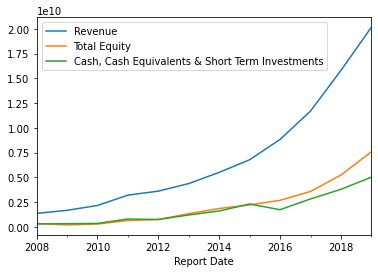

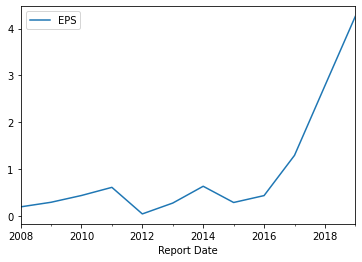

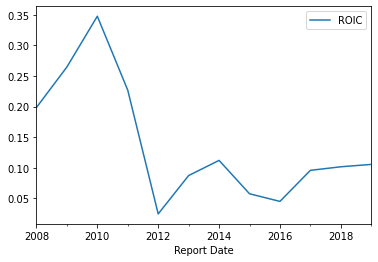

In [13]:
big_five_df[test_symbol].loc[[REVENUE, TOTAL_EQUITY, CASH_EQUIV_ST_INVEST]].T.plot()
big_five_df[test_symbol].loc[['EPS']].T.plot()
big_five_df[test_symbol].loc[['ROIC']].T.plot()

In [14]:
growth_rate_df.loc[test_symbol]

,10-year growth rate,5-year growth rate,3-year growth rate,1-year growth rate
financial,,,,
Total Equity,0.439007,0.324839,0.414371,0.447318
"Cash, Cash Equivalents & Short Term Investments",0.316767,0.255538,0.425142,0.322561
Revenue,0.282811,0.296393,0.316659,0.276182
EPS,0.307231,0.463846,1.139659,0.532786
ROIC,-0.087862,-0.011971,0.328283,0.038335


In [15]:
current_eps = big_five_df[test_symbol].loc['EPS'][-1]
current_eps

4.264322211791256

In [16]:
esimated_eps_growth_rate = 0.3
estimated_future_pe = esimated_eps_growth_rate * 100 * 2

In [17]:
future_eps = current_eps * (1 + esimated_eps_growth_rate) ** 10
future_price = future_eps * estimated_future_pe
future_price

3527.238173254408

In [18]:
today_sticker_price = future_price / (1.15 ** 10)
today_sticker_price

871.8793312777178

In [19]:
mos_price = today_sticker_price / 2
mos_price

435.9396656388589

In [20]:
def calculate_mos_price(symbol):
    current_eps = big_five_df[symbol].loc['EPS'][-1]

    esimated_eps_growth_rate = growth_rate_df.loc[symbol, TOTAL_EQUITY].mean()

    estimated_future_pe = esimated_eps_growth_rate * 100 * 2

    future_eps = current_eps * (1 + esimated_eps_growth_rate) ** 10

    future_price = future_eps * estimated_future_pe

    today_sticker_price = future_price / (1.15 ** 10)

    return today_sticker_price

def get_current_price(symbol):
    try:
        stock = yf.Ticker(symbol)
        return (stock.info['bid'] + stock.info['ask'])/2
    except:
        return math.nan

In [21]:
# takes 2.5 hours to run :/

# import datetime
# with open('./sticker.csv', 'a') as f:
#     f.write("ticker,sticker,current\n")
#     for i, ticker in enumerate(list(tickers_set)):
#         sticker_price = calculate_mos_price(ticker)
#         current_price = get_current_price(ticker)
#         f.write(f'{ticker},{sticker_price},{current_price}\n')
#         print(f'{datetime.datetime.now()}: {i}')

In [22]:
len(tickers_set)

2284

In [23]:
sticker_df = pd.read_csv('./sticker2.csv')
sticker_df

,ticker,sticker,current
0,WTW,-2.977994,NaN
1,TJX,37.893197,62.760
2,KRO,7.107841,15.480
3,EMGL,-93.444245,NaN
4,GME,1.961395,138.290
...,...,...,...
2219,GLPI,-3.029083,43.175
2220,PRCP,0.970865,NaN
2221,XSPY,-8.625719,NaN
2222,ARRS,152.275682,NaN


In [24]:
good_buy_tickers = list(sticker_df[sticker_df['current'] < sticker_df['sticker']]['ticker'])

In [25]:
good_buy_tickers

['FF',
 'ICUI',
 'MDXG',
 'HEAR',
 'AMD',
 'LB',
 'SCND',
 'ENR',
 'IEHC',
 'AIMC',
 'NEU',
 'GNRC',
 'TYL',
 'JCOM',
 'PBI',
 'WING',
 'MPC',
 'CUZ',
 'BCEI',
 'PRKA',
 'DOMO',
 'CCS',
 'SOFO',
 'BRRE',
 'FFIV',
 'ARNA',
 'STOR',
 'KBR',
 'MCD',
 'SSYS',
 'MTOR',
 'SUI',
 'CPSI',
 'ARCW',
 'INVA',
 'CHTR',
 'HBI',
 'TCMD',
 'NXST',
 'REI',
 'CVS',
 'JLL',
 'XBIT',
 'APPF',
 'T',
 'TPX',
 'PVAC',
 'ATO',
 'ALGT',
 'BLDR',
 'AMSC',
 'EVI',
 'WAB',
 'LGL',
 'BAH',
 'MEI',
 'QNST',
 'RCL',
 'CLCT',
 'REXR',
 'SUPN',
 'IO',
 'EPM',
 'PII',
 'NAII',
 'TU',
 'VEEV',
 'IMGN',
 'ZM',
 'ACIA',
 'AMZN',
 'OLLI',
 'LGIH',
 'SIX',
 'WSTL',
 'LAD',
 'PLNT',
 'LCI',
 'EAT',
 'CRM',
 'LEGH',
 'STX',
 'VRTX',
 'SOTK',
 'CAGU',
 'TCX',
 'PTN',
 'LGND',
 'TWTR',
 'QDEL',
 'TSN',
 'RMCF',
 'DEI',
 'URI',
 'NFLX',
 'CRSP',
 'ILMN',
 'LBUY',
 'INCY',
 'NCLH',
 'PCTY',
 'KDP',
 'CCK',
 'ATKR',
 'CORT',
 'NGVT',
 'IRBT',
 'CAG',
 'AWI',
 'TTD',
 'JYNT',
 'AL',
 'WRK',
 'LNG',
 'MIDD',
 'CIK',
 'EXEL',
 'EHTH

In [26]:
symbol = 'VZ'
growth_rate_df.loc[symbol]

,10-year growth rate,5-year growth rate,3-year growth rate,1-year growth rate
financial,,,,
Total Equity,-0.028778,0.356590,0.377645,0.148510
"Cash, Cash Equivalents & Short Term Investments",0.003738,-0.253009,-0.034262,-0.055009
Revenue,0.020349,0.007426,0.015343,0.007680
EPS,0.104533,0.139623,0.131074,0.237664
ROIC,0.050176,0.047980,0.047837,0.119851


<AxesSubplot:xlabel='Report Date'>

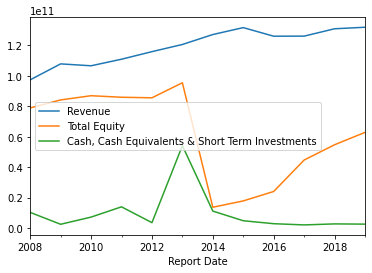

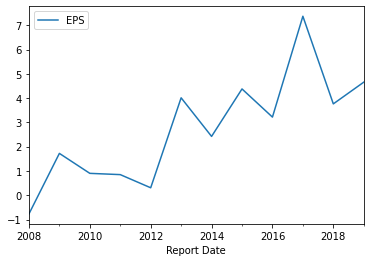

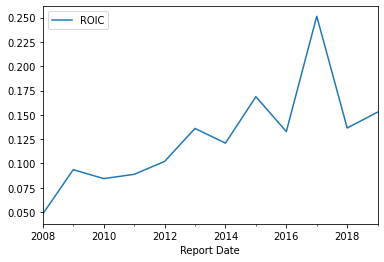

In [27]:
big_five_df[symbol].loc[[REVENUE, TOTAL_EQUITY, CASH_EQUIV_ST_INVEST]].T.plot()
big_five_df[symbol].loc[['EPS']].T.plot()
big_five_df[symbol].loc[['ROIC']].T.plot()

In [28]:
watch_out = []

for ticker in good_buy_tickers:
    try:
        if check_is_potential_buy(growth_rate_df.loc[ticker], 3):
            watch_out.append(ticker)
    except:
        print(f'Error checking {ticker}')

watch_out

Error checking REI
Error checking EPM


['AMZN', 'NFLX', 'ASGN', 'LULU', 'CNC']